In [1]:
from nemo.collections import nlp as nemo_nlp
from nemo.utils.exp_manager import exp_manager

import os
import wget 
import torch
import pytorch_lightning as pl
from omegaconf import OmegaConf

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
[NeMo W 2020-10-22 17:12:27 experimental:28] Module <class 'nemo.collections.nlp.modules.common.huggingface.auto.AutoModelEncoder'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-22 17:12:27 experimental:28] Module <class 'nemo.collections.nlp.modules.common.megatron.megatron_bert.MegatronBertEncoder'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In this tutorial, we are going to describe how to finetune BioMegatron - a [BERT](https://arxiv.org/abs/1810.04805)-like [Megatron-LM](https://arxiv.org/pdf/1909.08053.pdf) model pre-trained on large biomedical text corpus ([PubMed](https://pubmed.ncbi.nlm.nih.gov/) abstracts and full-text commercial use collection) - on the [NCBI Disease Dataset](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3951655/) for Named Entity Recognition.

The model size of Megatron-LM can be larger than BERT, up to multi-billion parameters, compared to 345 million parameters of BERT-large.
There are some alternatives of BioMegatron, most notably [BioBERT](https://arxiv.org/abs/1901.08746). Compared to BioBERT BioMegatron is larger by model size and pre-trained on larger text corpus.

A more general tutorial of using BERT-based models, including Megatron-LM, for downstream natural language processing tasks can be found [here](https://github.com/NVIDIA/NeMo/blob/main/tutorials/nlp/01_Pretrained_Language_Models_for_Downstream_Tasks.ipynb).

# Task Description
**Named entity recognition (NER)**, also referred to as entity chunking, identification or extraction, is the task of detecting and classifying key information (entities) in text.

For instance, **given sentences from medical abstracts, what diseases are mentioned?**<br>
In this case, our data input is sentences from the abstracts, and our labels are the precise locations of the named disease entities.  Take a look at the information provided for the dataset.

For more details and general examples on Named Entity Recognition, please refer to the [Token Classification and Named Entity Recognition tutorial notebook](https://github.com/NVIDIA/NeMo/blob/main/tutorials/nlp/Token_Classification_Named_Entity_Recognition.ipynb).

# Dataset

The [NCBI-disease corpus](https://www.ncbi.nlm.nih.gov/CBBresearch/Dogan/DISEASE/) is a set of 793 PubMed abstracts, annotated by 14 annotators. The annotations take the form of HTML-style tags inserted into the abstract text using the clearly defined rules.  The annotations identify named diseases, and can be used to fine-tune a language model to identify disease mentions in future abstracts, *whether those diseases were part of the original training set or not*.

Here's an example of what an annotated abstract from the corpus looks like:

```html
10021369	Identification of APC2, a homologue of the <category="Modifier">adenomatous polyposis coli tumour</category> suppressor .	The <category="Modifier">adenomatous polyposis coli ( APC ) tumour</category>-suppressor protein controls the Wnt signalling pathway by forming a complex with glycogen synthase kinase 3beta ( GSK-3beta ) , axin / conductin and betacatenin . Complex formation induces the rapid degradation of betacatenin . In <category="Modifier">colon carcinoma</category> cells , loss of APC leads to the accumulation of betacatenin in the nucleus , where it binds to and activates the Tcf-4 transcription factor ( reviewed in [ 1 ] [ 2 ] ) . Here , we report the identification and genomic structure of APC homologues . Mammalian APC2 , which closely resembles APC in overall domain structure , was functionally analyzed and shown to contain two SAMP domains , both of which are required for binding to conductin . Like APC , APC2 regulates the formation of active betacatenin-Tcf complexes , as demonstrated using transient transcriptional activation assays in APC - / - <category="Modifier">colon carcinoma</category> cells . Human APC2 maps to chromosome 19p13 . 3 . APC and APC2 may therefore have comparable functions in development and <category="SpecificDisease">cancer</category> .
```

In this example, we see the following tags within the abstract:
```html
<category="Modifier">adenomatous polyposis coli tumour</category>
<category="Modifier">adenomatous polyposis coli ( APC ) tumour</category>
<category="Modifier">colon carcinoma</category>
<category="Modifier">colon carcinoma</category>
<category="SpecificDisease">cancer</category>
```

For our purposes, we will consider any identified category (such as "Modifier", "Specific Disease", and a few others) to generally be a "disease".

Let's download the dataset.

In [2]:
!ls

cleanse.sh	     mlruns
containersetup.sh    my_GLUE_Benchmark.ipynb
create_data.py	     my_Token_Classification-BioMegatron.ipynb
DATA_DIR	     NeMo
go-gluetask.sh	     nemo_experiments
go-NERNLP.sh	     setup_data.sh
launch-nemo-2009.sh  setup_jupyter_env.ipynb
launch-nemo-glue.sh  wandb
launch-nemo-ner.sh   WORK_DIR


In [3]:
DATA_DIR = "DATA_DIR"
# os.makedirs(DATA_DIR, exist_ok=True)
# os.makedirs(os.path.join(DATA_DIR, 'NER'), exist_ok=True)

If you want to see more examples, you can explore the text of the corpus using the file browser to the left, or open files directly, for example typing a command like the following in a code-cell:
<pre><code>
! head -1 $DATA_DIR/NCBI_corpus_testing.txt
</code></pre>

In [4]:
! head -1 $DATA_DIR/NCBI_corpus_testing.txt

head: cannot open 'DATA_DIR/NCBI_corpus_testing.txt' for reading: No such file or directory


We have two datasets derived from this corpus:  a text classification dataset and a named entity recognition (NER) dataset.  The text classification dataset labels the abstracts among three broad disease groupings.  We'll use this simple split to demonstrate the NLP text classification task.   The NER dataset labels individual words as diseases.  This dataset will be used for the NLP NER task.  

## Pre-process dataset
A pre-processed NCBI-disease dataset for NER can be found [here](https://github.com/spyysalo/ncbi-disease/tree/master/conll) or [here](https://github.com/dmis-lab/biobert#datasets).<br>
We download the files under {DATA_DIR/NER} directory.

In [5]:
NER_DATA_DIR = 'DATA_DIR/NER'
!ls -lh $NER_DATA_DIR

total 4.6M
-rwxrwxrwx 1 root root 196K Oct 22 16:36 dev.tsv
-rwxrwxrwx 1 root root  63K Oct 22 16:38 labels_dev.txt
-rwxrwxrwx 1 root root  65K Oct 22 16:38 labels_test.txt
-rwxrwxrwx 1 root root 360K Oct 22 16:38 labels_train.txt
-rwxrwxrwx 1 root root 162K Oct 22 16:36 NCBI_corpus_development.txt
-rwxrwxrwx 1 root root 171K Oct 22 16:36 NCBI_corpus_testing.txt
-rwxrwxrwx 1 root root 938K Oct 22 16:36 NCBI_corpus_training.txt
-rwxrwxrwx 1 root root 360K Oct 22 16:36 NCBI_corpus.zip
-rwxrwxrwx 1 root root 6.7K Oct 22 16:51 sample_labels_dev.txt
-rwxrwxrwx 1 root root  15K Oct 22 16:51 sample_text_dev.txt
-rwxrwxrwx 1 root root 201K Oct 22 16:36 test.tsv
-rwxrwxrwx 1 root root 135K Oct 22 16:38 text_dev.txt
-rwxrwxrwx 1 root root 138K Oct 22 16:38 text_test.txt
-rwxrwxrwx 1 root root 760K Oct 22 16:38 text_train.txt
-rwxrwxrwx 1 root root 1.1M Oct 22 16:36 train.tsv


Convert these to a format that is compatible with [NeMo Token Classification module](https://github.com/NVIDIA/NeMo/blob/main/examples/nlp/token_classification/token_classification.py), using the [conversion script](https://github.com/NVIDIA/NeMo/blob/main/examples/nlp/token_classification/data/import_from_iob_format.py).

The NER task requires two files: the text sentences, and the labels.  Run the next two cells to see a sample of the two files.

In [6]:
!head $NER_DATA_DIR/text_train.txt

Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor . 
The adenomatous polyposis coli ( APC ) tumour - suppressor protein controls the Wnt signalling pathway by forming a complex with glycogen synthase kinase 3beta ( GSK - 3beta ) , axin / conductin and betacatenin . 
Complex formation induces the rapid degradation of betacatenin . 
In colon carcinoma cells , loss of APC leads to the accumulation of betacatenin in the nucleus , where it binds to and activates the Tcf - 4 transcription factor ( reviewed in [ 1 ] [ 2 ] ) . 
Here , we report the identification and genomic structure of APC homologues . 
Mammalian APC2 , which closely resembles APC in overall domain structure , was functionally analyzed and shown to contain two SAMP domains , both of which are required for binding to conductin . 
Like APC , APC2 regulates the formation of active betacatenin - Tcf complexes , as demonstrated using transient transcriptional activation assays in APC - / - c

In [7]:
!head $NER_DATA_DIR/labels_train.txt

O O O O O O O O B-Disease I-Disease I-Disease I-Disease O O 
O B-Disease I-Disease I-Disease I-Disease I-Disease I-Disease I-Disease O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 
O O O O O O O O O 
O B-Disease I-Disease O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 
O O O O O O O O O O O O O 
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 
O O O O O O O O O O O O O O O O O O O O O O O O O O B-Disease I-Disease O O 
O O O O O O O 
O O 
O O O O O O O O O O O B-Disease O 


### IOB Tagging
We can see that the abstract has been broken into sentences.  Each sentence is then further parsed into words with labels that correspond to the original HTML-style tags in the corpus. 

The sentences and labels in the NER dataset map to each other with _inside, outside, beginning (IOB)_ tagging. Anything separated by white space is a word, including punctuation.  For the first sentence we have the following mapping:

```text
Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .
O              O  O    O O O         O  O   B           I         I    I      O          O  
```

Recall the original corpus tags:
```html
Identification of APC2, a homologue of the <category="Modifier">adenomatous polyposis coli tumour</category> suppressor .
```
The beginning word of the tagged text, "adenomatous", is now IOB-tagged with a <span style="font-family:verdana;font-size:110%;">B</span> (beginning) tag, the other parts of the disease, "polyposis coli tumour" tagged with <span style="font-family:verdana;font-size:110%;">I</span> (inside) tags, and everything else tagged as <span style="font-family:verdana;font-size:110%;">O</span> (outside).

# Model configuration

Our Named Entity Recognition model is comprised of the pretrained [BERT](https://arxiv.org/pdf/1810.04805.pdf) model followed by a Token Classification layer.

The model is defined in a config file which declares multiple important sections. They are:
- **model**: All arguments that are related to the Model - language model, token classifier, optimizer and schedulers, datasets and any other related information

- **trainer**: Any argument to be passed to PyTorch Lightning

In [8]:
WORK_DIR = "WORK_DIR"
os.makedirs(WORK_DIR, exist_ok=True)
MODEL_CONFIG = "token_classification_config.yaml"

In [9]:
# download the model's configuration file 
config_dir = WORK_DIR + '/configs/'
os.makedirs(config_dir, exist_ok=True)
if not os.path.exists(config_dir + MODEL_CONFIG):
    print('Downloading config file...')
    wget.download('https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/nlp/token_classification/conf/' + MODEL_CONFIG, config_dir)
else:
    print ('config file is already exists')

In [10]:
# this line will print the entire config of the model
config_path = f'{WORK_DIR}/configs/{MODEL_CONFIG}'
print(config_path)
config = OmegaConf.load(config_path)
# Note: these are small batch-sizes - increase as appropriate to available GPU capacity
config.model.train_ds.batch_size=12#16#12#8
config.model.validation_ds.batch_size=12#16#12#8

WORK_DIR/configs/token_classification_config.yaml


In [11]:
print(OmegaConf.to_yaml(config))

pretrained_model: null
trainer:
  gpus: 1
  num_nodes: 1
  max_epochs: 5
  max_steps: null
  accumulate_grad_batches: 1
  gradient_clip_val: 0.0
  amp_level: O0
  precision: 16
  accelerator: ddp
  checkpoint_callback: false
  logger: false
  log_every_n_steps: 1
  val_check_interval: 1.0
  resume_from_checkpoint: null
exp_manager:
  exp_dir: null
  name: token_classification_model
  create_tensorboard_logger: true
  create_checkpoint_callback: true
model:
  nemo_path: null
  label_ids: null
  dataset:
    data_dir: ???
    class_balancing: null
    max_seq_length: 128
    pad_label: O
    ignore_extra_tokens: false
    ignore_start_end: false
    use_cache: true
    num_workers: 2
    pin_memory: false
    drop_last: false
  train_ds:
    text_file: text_train.txt
    labels_file: labels_train.txt
    shuffle: true
    num_samples: -1
    batch_size: 12
  validation_ds:
    text_file: text_dev.txt
    labels_file: labels_dev.txt
    shuffle: false
    num_samples: -1
    batch_size: 1

# Model Training
## Setting up Data within the config

Among other things, the config file contains dictionaries called dataset, train_ds and validation_ds. These are configurations used to setup the Dataset and DataLoaders of the corresponding config.

We assume that both training and evaluation files are located in the same directory, and use the default names mentioned during the data download step. 
So, to start model training, we simply need to specify `model.dataset.data_dir`, like we are going to do below.

Also notice that some config lines, including `model.dataset.data_dir`, have `???` in place of paths, this means that values for these fields are required to be specified by the user.

Let's now add the data directory path to the config.

In [12]:
# in this tutorial train and dev datasets are located in the same folder, so it is enought to add the path of the data directory to the config
config.model.dataset.data_dir = os.path.join(DATA_DIR, 'NER')

# if you want to decrease the size of your datasets, uncomment the lines below:
# NUM_SAMPLES = 1000
# config.model.train_ds.num_samples = NUM_SAMPLES
# config.model.validation_ds.num_samples = NUM_SAMPLES

## Building the PyTorch Lightning Trainer

NeMo models are primarily PyTorch Lightning modules - and therefore are entirely compatible with the PyTorch Lightning ecosystem.

Let's first instantiate a Trainer object

In [13]:
print("Trainer config - \n")
print(OmegaConf.to_yaml(config.trainer))

Trainer config - 

gpus: 1
num_nodes: 1
max_epochs: 5
max_steps: null
accumulate_grad_batches: 1
gradient_clip_val: 0.0
amp_level: O0
precision: 16
accelerator: ddp
checkpoint_callback: false
logger: false
log_every_n_steps: 1
val_check_interval: 1.0
resume_from_checkpoint: null



In [14]:
# lets modify some trainer configs
# checks if we have GPU available and uses it
cuda = 1 if torch.cuda.is_available() else 0
config.trainer.gpus = cuda

# config.trainer.precision = 16 if torch.cuda.is_available() else 32
config.trainer.precision = 32

config.model.dataset.num_workers=4 
config.model.optim.lr=4.232e-04

# for mixed precision training(requires APEX), uncomment the line below (precision should be set to 16 and amp_level to O1):
# config.trainer.amp_level=O1

# remove distributed training flags
# config.trainer.distributed_backend=ddp 
# config.trainer.distributed_backend=None
# config.trainer.distributed_backend='dp'

# setup max number of steps to reduce training time for demonstration purposes of this tutorial
# config.trainer.max_steps=500

# setup max number of epochs 
config.trainer.max_epochs=1#1

# does not save checkpoints (faster training iterations without saves) 
config.exp_manager.create_checkpoint_callback=False

trainer = pl.Trainer(**config.trainer)

GPU available: True, used: True
INFO - GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO - TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Setting up a NeMo Experiment¶

NeMo has an experiment manager that handles logging and checkpointing for us, so let's use it:

In [15]:
exp_dir = exp_manager(trainer, config.get("exp_manager", None))

# the exp_dir provides a path to the current experiment for easy access
exp_dir = str(exp_dir)
exp_dir

[NeMo I 2020-10-22 17:12:29 exp_manager:169] Experiments will be logged at /mnt/batch/tasks/shared/LS_root/mounts/clusters/vac20amlofgpuv100-tr11/code/Users/Johnathon.Stringer/AzureML-NeMo/nemo_experiments/token_classification_model/2020-10-22_17-12-29
[NeMo I 2020-10-22 17:12:30 exp_manager:503] TensorboardLogger has been set up


'/mnt/batch/tasks/shared/LS_root/mounts/clusters/vac20amlofgpuv100-tr11/code/Users/Johnathon.Stringer/AzureML-NeMo/nemo_experiments/token_classification_model/2020-10-22_17-12-29'

In [16]:
# complete list of supported BERT-like models
print(nemo_nlp.modules.get_pretrained_lm_models_list())

# specify BERT-like model, you want to use
PRETRAINED_BERT_MODEL = "biomegatron-bert-345m-cased"

['megatron-bert-345m-uncased', 'megatron-bert-345m-cased', 'megatron-bert-uncased', 'megatron-bert-cased', 'biomegatron-bert-345m-uncased', 'biomegatron-bert-345m-cased', 'bert-base-uncased', 'bert-large-uncased', 'bert-base-cased', 'bert-large-cased', 'bert-base-multilingual-uncased', 'bert-base-multilingual-cased', 'bert-base-chinese', 'bert-base-german-cased', 'bert-large-uncased-whole-word-masking', 'bert-large-cased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad', 'bert-large-cased-whole-word-masking-finetuned-squad', 'bert-base-cased-finetuned-mrpc', 'bert-base-german-dbmdz-cased', 'bert-base-german-dbmdz-uncased', 'cl-tohoku/bert-base-japanese', 'cl-tohoku/bert-base-japanese-whole-word-masking', 'cl-tohoku/bert-base-japanese-char', 'cl-tohoku/bert-base-japanese-char-whole-word-masking', 'TurkuNLP/bert-base-finnish-cased-v1', 'TurkuNLP/bert-base-finnish-uncased-v1', 'wietsedv/bert-base-dutch-cased', 'distilbert-base-uncased', 'distilbert-base-uncased-

In [17]:
# add the specified above model parameters to the config
config.model.language_model.pretrained_model_name = PRETRAINED_BERT_MODEL

Now, we are ready to initialize our model. During the model initialization call, the dataset and data loaders we'll be prepared for training and evaluation.
Also, the pretrained BERT model will be downloaded, note it can take up to a few minutes depending on the size of the chosen BERT model.

In [18]:
model_ner = nemo_nlp.models.TokenClassificationModel(cfg=config.model, trainer=trainer)

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


[NeMo I 2020-10-22 17:12:31 token_classification_model:97] Setting model.dataset.data_dir to DATA_DIR/NER.
[NeMo I 2020-10-22 17:12:31 token_classification_descriptor:70] Labels: {'O': 0, 'B-Disease': 1, 'I-Disease': 2}
[NeMo I 2020-10-22 17:12:31 token_classification_descriptor:75] Labels mapping saved to : DATA_DIR/NER/label_ids.csv
[NeMo I 2020-10-22 17:12:31 token_classification_descriptor:78] Three most popular labels in train dataset:
[NeMo I 2020-10-22 17:12:31 data_preprocessing:131] label: 0, 124819 out of 136086 (91.72%).
[NeMo I 2020-10-22 17:12:31 data_preprocessing:131] label: 2, 6122 out of 136086 (4.50%).
[NeMo I 2020-10-22 17:12:31 data_preprocessing:131] label: 1, 5145 out of 136086 (3.78%).
[NeMo I 2020-10-22 17:12:31 token_classification_descriptor:83] Total labels: 136086
[NeMo I 2020-10-22 17:12:31 token_classification_descriptor:84] Label frequencies - {0: 124819, 2: 6122, 1: 5145}
[NeMo I 2020-10-22 17:12:31 token_classification_descriptor:88] Class Weights: {0: 

[NeMo W 2020-10-22 17:12:40 token_classification_dataset:145] 8 are longer than 128


[NeMo I 2020-10-22 17:12:40 token_classification_dataset:148] *** Example ***
[NeMo I 2020-10-22 17:12:40 token_classification_dataset:149] i: 0
[NeMo I 2020-10-22 17:12:40 token_classification_dataset:150] subtokens: [CLS] I ##dent ##ification of AP ##C ##2 , a ho ##mo ##logue of the ad ##eno ##mat ##ous p ##oly ##po ##sis co ##li t ##umour suppress ##or . [SEP]
[NeMo I 2020-10-22 17:12:40 token_classification_dataset:151] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-10-22 17:12:40 token_classification_dataset:152] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[NeMo W 2020-10-22 17:12:42 token_classification_dataset:145] 0 are longer than 122


[NeMo I 2020-10-22 17:12:42 token_classification_dataset:148] *** Example ***
[NeMo I 2020-10-22 17:12:42 token_classification_dataset:149] i: 0
[NeMo I 2020-10-22 17:12:42 token_classification_dataset:150] subtokens: [CLS] BR ##CA ##1 is secret ##ed and exhibits properties of a g ##rani ##n . [SEP]
[NeMo I 2020-10-22 17:12:42 token_classification_dataset:151] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-10-22 17:12:42 token_classification_dataset:152] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-10-22 17:12:42 token_classification_dataset:153] su

## Monitoring training progress
Optionally, you can create a Tensorboard visualization to monitor training progress.
If you're not using Colab, refer to [https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) if you're facing issues with running the cell below.

In [19]:
try:
    from google import colab
    COLAB_ENV = True
except (ImportError, ModuleNotFoundError):
    COLAB_ENV = False

# Load the TensorBoard notebook extension
if COLAB_ENV:
    %load_ext tensorboard
    %tensorboard --logdir {exp_dir}
else:
    print("To use tensorboard, please use this notebook in a Google Colab environment.")

To use tensorboard, please use this notebook in a Google Colab environment.


In [20]:
# start model training
trainer.fit(model_ner)

initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1
INFO - initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1


[NeMo I 2020-10-22 17:12:50 modelPT:583] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        lr: 0.0004232
        weight_decay: 0.0
    )
[NeMo I 2020-10-22 17:12:50 lr_scheduler:554] Scheduler "<nemo.core.optim.lr_scheduler.WarmupAnnealing object at 0x7fda6c8cc748>" 
    will be used during training (effective maximum steps = 453) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: 0.1
    last_epoch: -1
    max_steps: 453
    )



  | Name                  | Type                 | Params
---------------------------------------------------------------
0 | bert_model            | MegatronBertEncoder  | 332 M 
1 | classifier            | TokenClassifier      | 1 M   
2 | loss                  | CrossEntropyLoss     | 0     
3 | classification_report | ClassificationReport | 0     
INFO - 
  | Name                  | Type                 | Params
---------------------------------------------------------------
0 | bert_model            | MegatronBertEncoder  | 332 M 
1 | classifier            | TokenClassifier      | 1 M   
2 | loss                  | CrossEntropyLoss     | 0     
3 | classification_report | ClassificationReport | 0     


torch distributed is already initialized, skipping initialization ...
> initializing model parallel with size 1
> setting random seeds to 1234 ...
> initializing model parallel cuda seeds on global rank 0, model parallel rank 0, and data parallel rank 0 with model parallel seed: 3952 and data parallel seed: 1234


[NeMo W 2020-10-22 17:12:50 nemo_logging:349] /anaconda/envs/azureml_py36/lib/python3.6/site-packages/nemo/collections/nlp/metrics/classification_report.py:116: UserWarning: This overload of nonzero is deprecated:
    	nonzero(Tensor input, *, Tensor out)
    Consider using one of the following signatures instead:
    	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
      num_non_empty_classes = torch.nonzero(self.num_examples_per_class).size(0)
    


[NeMo I 2020-10-22 17:12:51 token_classification_model:173] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         93.47      84.89      88.97        556
    B-Disease (label_id: 1)                                  0.00       0.00       0.00         17
    I-Disease (label_id: 2)                                  2.27      10.00       3.70         20
    -------------------
    micro avg                                               79.93      79.93      79.93        593
    macro avg                                               31.91      31.63      30.89        593
    weighted avg                                            87.71      79.93      83.55        593
    


[NeMo I 2020-10-22 17:15:55 token_classification_model:173] 
    label                                                precision    recall       f1           support   
    O (label_id: 0)                                         97.35      98.91      98.12      22092
    B-Disease (label_id: 1)                                 38.02      31.26      34.31        787
    I-Disease (label_id: 2)                                 60.62      48.72      54.02       1090
    -------------------
    micro avg                                               94.41      94.41      94.41      23969
    macro avg                                               65.33      59.63      62.15      23969
    weighted avg                                            93.73      94.41      94.02      23969
    



1

# Inference

To see how the model performs, we can run generate prediction similar to the way we did it earlier

Now, let's generate predictions for the provided text file.
If labels file is also specified, the model will evaluate the predictions and plot confusion matrix. 

[NeMo I 2020-10-22 17:15:58 token_classification_dataset:116] Setting Max Seq length to: 122
[NeMo I 2020-10-22 17:15:58 data_preprocessing:295] Some stats of the lengths of the sequences:
[NeMo I 2020-10-22 17:15:58 data_preprocessing:301] Min: 4 |                  Max: 122 |                  Mean: 36.812567713976165 |                  Median: 34.0
[NeMo I 2020-10-22 17:15:58 data_preprocessing:303] 75 percentile: 47.00
[NeMo I 2020-10-22 17:15:58 data_preprocessing:304] 99 percentile: 83.56


[NeMo W 2020-10-22 17:15:58 token_classification_dataset:145] 0 are longer than 122


[NeMo I 2020-10-22 17:15:58 token_classification_dataset:148] *** Example ***
[NeMo I 2020-10-22 17:15:58 token_classification_dataset:149] i: 0
[NeMo I 2020-10-22 17:15:58 token_classification_dataset:150] subtokens: [CLS] BR ##CA ##1 is secret ##ed and exhibits properties of a g ##rani ##n . [SEP]
[NeMo I 2020-10-22 17:15:58 token_classification_dataset:151] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-10-22 17:15:58 token_classification_dataset:152] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-10-22 17:15:58 token_classification_dataset:153] su

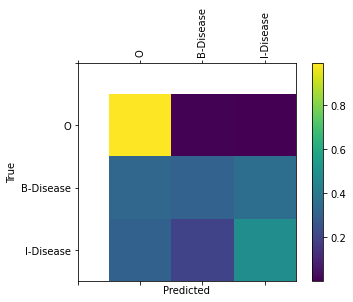

In [21]:
model_ner.evaluate_from_file(
    text_file=os.path.join(DATA_DIR, 'NER', 'text_dev.txt'),
    labels_file=os.path.join(DATA_DIR, 'NER', 'labels_dev.txt'),
    output_dir=exp_dir,
    add_confusion_matrix=True,
    normalize_confusion_matrix=True,
    batch_size=1
)
# Please check matplotlib version if encountering any error plotting confusion matrix:
# https://stackoverflow.com/questions/63212347/importerror-cannot-import-name-png-from-matplotlib

## Training Script

If you have NeMo installed locally, you can also train the model with `nlp/token_classification/token_classification.py.`

To run training script, use:

`python token_classification.py model.dataset.data_dir=PATH_TO_DATA_DIR PRETRAINED_BERT_MODEL=biomegatron-bert-345m-cased`

The training could take several minutes and the result should look something like
```
[NeMo I 2020-05-22 17:13:48 token_classification_callback:82] Accuracy: 0.9882348032875798
[NeMo I 2020-05-22 17:13:48 token_classification_callback:86] F1 weighted: 98.82
[NeMo I 2020-05-22 17:13:48 token_classification_callback:86] F1 macro: 93.74
[NeMo I 2020-05-22 17:13:48 token_classification_callback:86] F1 micro: 98.82
[NeMo I 2020-05-22 17:13:49 token_classification_callback:89] precision    recall  f1-score   support
    
    O (label id: 0)     0.9938    0.9957    0.9947     22092
    B (label id: 1)     0.8843    0.9034    0.8938       787
    I (label id: 2)     0.9505    0.8982    0.9236      1090
    
           accuracy                         0.9882     23969
          macro avg     0.9429    0.9324    0.9374     23969
       weighted avg     0.9882    0.9882    0.9882     23969
```